## Pneumonia Detection from x-rays

  - `Pneumonia` is an infection in one or both lungs. Bacteria, viruses, and fungi cause it. The infection causes inflammation in the air sacs in your lungs, which are called alveoli. The alveoli fill with fluid or pus, making it difficult to breathe.

https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851az

- This link is to guide how to download dataset directly from `Kaggle`.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks/Internship/Kaggle"
## this is the path where kaggle.json is present in the Google Drive

In [ ]:
##changing the working directory
%cd /content/gdrive/MyDrive/Colab Notebooks/Internship/Kaggle

/content/gdrive/MyDrive/Colab Notebooks/Internship/Kaggle


In [ ]:
## this is the pythnon API Command for dowload dataset, uncomment below line for dowload data
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
# checking files in working directory
!ls

chest_xray  kaggle.json  pnemonia_data.pickle


In [ ]:
##unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

___________________


____________________

In [ ]:
# required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.math import confusion_matrix
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Dropout,Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
from keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152

In [ ]:
data_path = "/content/gdrive/MyDrive/Colab Notebooks/Internship/Kaggle/chest_xray/"

train_path = data_path + 'train'
test_path = data_path +'test'
val_path = data_path + 'val'

train_normal_path = train_path+'/NORMAL'
train_pneu_path = train_path+'/PNEUMONIA'

test_normal_path = test_path+'/NORMAL'
test_pneu_path = test_path+'/PNEUMONIA'

val_normal_path = val_path+'/NORMAL'
val_pneu_path = val_path+'/PNEUMONIA'


train_normal_img = glob(train_normal_path+'/*jpeg')
train_pneu_img = glob(train_pneu_path + '/*jpeg')

test_normal_img = glob(test_normal_path+'/*jpeg')
test_pneu_img = glob(test_pneu_path + '/*jpeg')

val_normal_img = glob(val_normal_path+'/*jpeg')
val_pneu_img = glob(val_pneu_path + '/*jpeg')

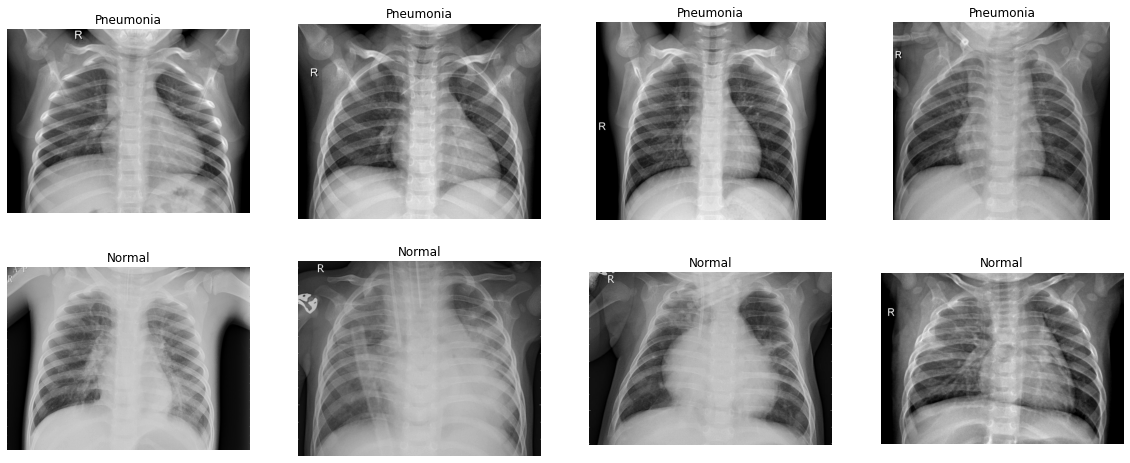

In [ ]:
## display some images
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_normal_img[:4]):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')  
for i,img_path in enumerate(train_pneu_img[:4]):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

## Data Augmentation

In [ ]:
# normalization , basically image pixel values are 0 to 255
train = ImageDataGenerator(rescale=1./255,
                           rotation_range=90,
                           zoom_range=0.2,
                           width_shift_range=0.2,
                           height_shift_range = 0.2,
                           horizontal_flip = True
                           ) # for traing data
validation = ImageDataGenerator(rescale=1./255,
                                rotation_range=90,
                           zoom_range=0.2,
                           width_shift_range=0.2,
                           height_shift_range = 0.2,
                           horizontal_flip = True) # for validation data
test = ImageDataGenerator(rescale=1./255)

In [ ]:
# for generating classes for traing data
train_data = train.flow_from_directory(train_path,
                                       target_size=(240,240),# resize image
                                       batch_size=32,# while traing NN
                                       class_mode='binary')# for generating classes

# for va;idation dataset
val_data = validation.flow_from_directory(val_path,
                                          target_size=(240,240),
                                          batch_size=32,
                                          class_mode="binary")
test_data = test.flow_from_directory(test_path,
                                          target_size=(240,240),
                                          batch_size=32,
                                          class_mode="binary")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
train_data.class_indices # class label

{'NORMAL': 0, 'PNEUMONIA': 1}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


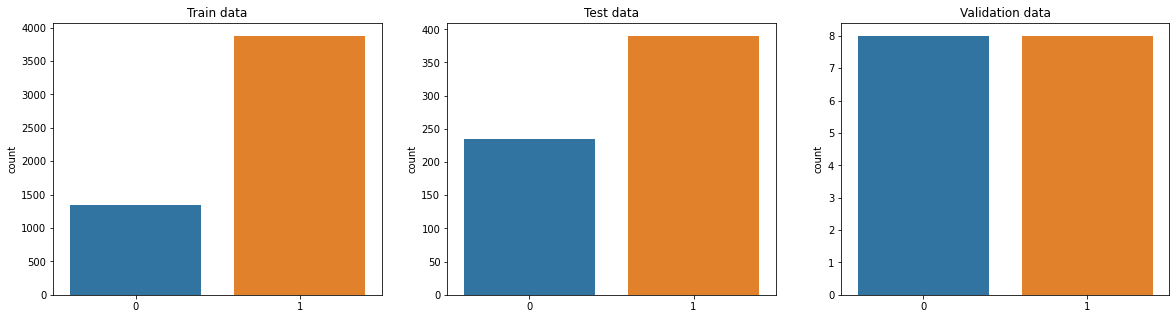

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_data.labels)
plt.title('Train data')

plt.subplot(1,3,2);
sns.countplot(test_data.labels)
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_data.labels)
plt.title('Validation data')
plt.show()

## Model Building

### CNN model

In [ ]:
model = None
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),input_shape=(240, 240, 3)))
# conv3
model.add(Conv2D(64, kernel_size=(3, 3), 
                 padding='same', 
                 activation='relu', 
                 ))
model.add(MaxPooling2D(pool_size=(2, 2)))
# conv3-128
model.add(Conv2D(128, (3, 3),
                 activation='relu',
                 ))
# Maxpooling
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Flatten
model.add(Flatten())
# FC-1
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 238, 238, 32)      896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 238, 238, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 119, 119, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 117, 117, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 58, 58, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 58, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 430592)           

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=5, verbose=1,
    mode='auto')

history = model.fit(train_data,epochs=5,validation_data=val_data,callbacks=[lr_reduce])

Epoch 1/5
163/163 [==============================] - 1187s 7s/step - loss: 0.6275 - accuracy: 0.7229 - val_loss: 0.9823 - val_accuracy: 0.5625
Epoch 2/5
163/163 [==============================] - 139s 850ms/step - loss: 0.4008 - accuracy: 0.8103 - val_loss: 1.4619 - val_accuracy: 0.6250
Epoch 3/5
163/163 [==============================] - 138s 847ms/step - loss: 0.3712 - accuracy: 0.8244 - val_loss: 0.9894 - val_accuracy: 0.6875
Epoch 4/5
163/163 [==============================] - 138s 843ms/step - loss: 0.3472 - accuracy: 0.8476 - val_loss: 1.1832 - val_accuracy: 0.7500
Epoch 5/5
163/163 [==============================] - 137s 842ms/step - loss: 0.3498 - accuracy: 0.8453 - val_loss: 1.6258 - val_accuracy: 0.6250


In [ ]:
loss, accu = model.evaluate(test_data)
print(f"Loss : {loss}\nAccuracy : {accu}")

20/20 [==============================] - 284s 15s/step - loss: 0.4081 - accuracy: 0.8125
Loss : 0.4080701172351837
Accuracy : 0.8125


In [ ]:
pred = model.predict_generator(test_data)
y_pred = np.argmax(pred, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


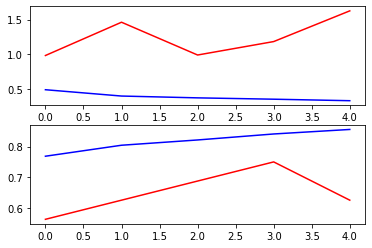

In [ ]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

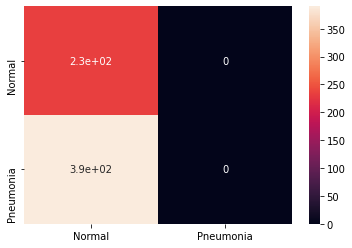

In [ ]:
cm = confusion_matrix(test_data.labels,y_pred)

sns.heatmap(cm,annot=True,xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])

## VGG16

In [ ]:
vgg16 = VGG16(include_top=False,weights='imagenet',
              input_shape=(240,240,3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg16.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg16.output)
predictions = Dense(1,activation='sigmoid')(x)
model = Model(inputs=vgg16.input,outputs=predictions)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0     

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_data,validation_data=val_data,epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(val_data))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
163/163 [==============================] - 156s 875ms/step - loss: 0.3567 - accuracy: 0.8325 - val_loss: 1.1420 - val_accuracy: 0.6250
Epoch 2/5
163/163 [==============================] - 137s 837ms/step - loss: 0.2300 - accuracy: 0.9084 - val_loss: 1.1514 - val_accuracy: 0.6250
Epoch 3/5
163/163 [==============================] - 137s 839ms/step - loss: 0.2171 - accuracy: 0.9123 - val_loss: 1.4339 - val_accuracy: 0.6250
Epoch 4/5
163/163 [==============================] - 138s 844ms/step - loss: 0.1886 - accuracy: 0.9256 - val_loss: 0.9792 - val_accuracy: 0.6875
Epoch 5/5
163/163 [==============================] - 138s 843ms/step - loss: 0.1736 - accuracy: 0.9276 - val_loss: 1.0630 - val_accuracy: 0.6250


In [ ]:
loss, accu = model.evaluate(test_data)
print(f"Loss : {loss}\nAccuracy : {accu}")

20/20 [==============================] - 9s 425ms/step - loss: 0.2277 - accuracy: 0.9087
Loss : 0.22770199179649353
Accuracy : 0.9086538553237915


In [ ]:
pred = model.predict_generator(test_data)
y_pred = np.argmax(pred, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


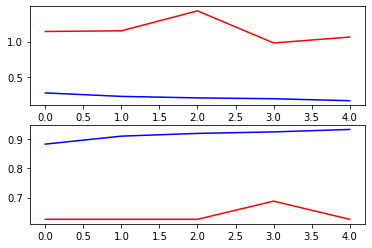

In [ ]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

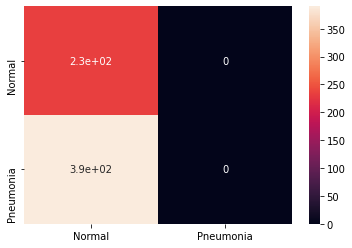

In [ ]:
cm = confusion_matrix(test_data.labels,y_pred)

sns.heatmap(cm,annot=True,xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])

## Resnet 50

In [ ]:
# Create model
model = None
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Dense(1, activation='sigmoid'))

# Do not train first layer (ResNet) as it is already pre-trained
model.layers[0].trainable = False

# Compile model 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94773248/94765736 [==============================] - 11s 0us/step


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
history=model.fit_generator(train_data,epochs=5,validation_data=val_data,steps_per_epoch=len(train_data),validation_steps=len(val_data))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
163/163 [==============================] - 143s 846ms/step - loss: 0.5811 - accuracy: 0.7321 - val_loss: 0.8454 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 136s 834ms/step - loss: 0.5355 - accuracy: 0.7512 - val_loss: 1.1008 - val_accuracy: 0.5000
Epoch 3/5
163/163 [==============================] - 136s 834ms/step - loss: 0.5241 - accuracy: 0.7472 - val_loss: 0.8574 - val_accuracy: 0.5000
Epoch 4/5
163/163 [==============================] - 135s 830ms/step - loss: 0.5177 - accuracy: 0.7475 - val_loss: 1.0694 - val_accuracy: 0.5000
Epoch 5/5
163/163 [==============================] - 136s 830ms/step - loss: 0.5118 - accuracy: 0.7385 - val_loss: 0.9605 - val_accuracy: 0.5000


In [ ]:
loss, accu = model.evaluate(test_data)
print(f"Loss : {loss}\nAccuracy : {accu}")

20/20 [==============================] - 8s 408ms/step - loss: 0.5885 - accuracy: 0.6330
Loss : 0.5885382294654846
Accuracy : 0.6330128312110901


In [ ]:
pred = model.predict_generator(test_data)
y_pred = np.argmax(pred, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


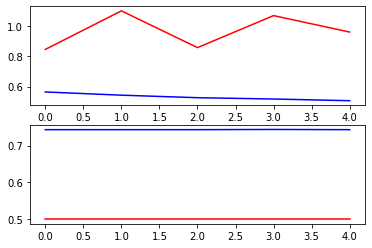

In [ ]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

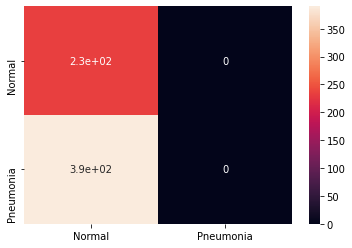

In [ ]:
cm = confusion_matrix(test_data.labels,y_pred)

sns.heatmap(cm,annot=True,xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])

## RestNet 152

In [ ]:
# Create model
model = None
model = Sequential()
model.add(ResNet152(include_top=False, pooling='avg', weights='imagenet'))
model.add(Dense(1, activation='sigmoid'))

# Do not train first layer (ResNet) as it is already pre-trained
model.layers[0].trainable = False

# Compile model 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2048)              58370944  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 58,372,993
Trainable params: 2,049
Non-trainable params: 58,370,944
_________________________________________________________________


In [ ]:
history=model.fit_generator(train_data,epochs=5,validation_data=val_data,steps_per_epoch=len(train_data),validation_steps=len(val_data))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
163/163 [==============================] - 171s 989ms/step - loss: 0.5949 - accuracy: 0.7221 - val_loss: 0.7850 - val_accuracy: 0.5000
Epoch 2/5
163/163 [==============================] - 158s 967ms/step - loss: 0.5272 - accuracy: 0.7544 - val_loss: 0.9106 - val_accuracy: 0.5000
Epoch 3/5
163/163 [==============================] - 157s 961ms/step - loss: 0.5083 - accuracy: 0.7412 - val_loss: 0.7317 - val_accuracy: 0.5000
Epoch 4/5
163/163 [==============================] - 156s 952ms/step - loss: 0.4887 - accuracy: 0.7620 - val_loss: 0.8431 - val_accuracy: 0.5625
Epoch 5/5
163/163 [==============================] - 158s 968ms/step - loss: 0.4841 - accuracy: 0.7579 - val_loss: 1.0411 - val_accuracy: 0.5625


In [ ]:
loss, accu = model.evaluate(test_data)
print(f"Loss : {loss}\nAccuracy : {accu}")

20/20 [==============================] - 13s 615ms/step - loss: 0.5742 - accuracy: 0.6362
Loss : 0.574225902557373
Accuracy : 0.6362179517745972


In [ ]:
pred = model.predict_generator(test_data)
y_pred = np.argmax(pred, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


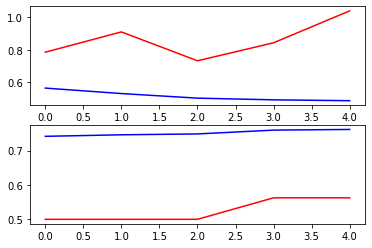

In [ ]:
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assign the first subplot to graph training loss and validation loss
ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

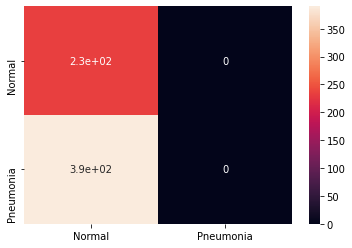

In [ ]:
cm = confusion_matrix(test_data.labels,y_pred)

sns.heatmap(cm,annot=True,xticklabels=['Normal', 'Pneumonia'],yticklabels=['Normal', 'Pneumonia'])

______________________


_______________________